## Pandas analysis

This exercise consists in analyzing a dataset containg timing information from a series of Time-to-Digital-Converters (TDC) implemented in a couple of FPGAs. Each measurement (i.e. each row of the input file) consists of a flag that specifies the type of message ('HEAD', which in this case is always 1), two addresses of the TDC providing the signal ('FPGA' and 'TDC_CHANNEL'), and the timing information ('ORBIT_CNT', 'BX_COUNTER', and 'TDC_MEAS'). Each TDC count corresponds to 25/30 ns, whereas a unit of BX_COUNTER corresponds to 25 ns, and the ORBIT_CNT is increased every 'x' BX_COUNTER. This allows to store the time in a similar way to hours, minutes and seconds.

In [1]:
# If you didn't download it yet, please get the relevant file now!
#!wget https://www.dropbox.com/s/xvjzaxzz3ysphme/data_000637.txt -P ~/data/

--2021-11-24 15:12:55--  https://www.dropbox.com/s/xvjzaxzz3ysphme/data_000637.txt
Resolving www.dropbox.com (www.dropbox.com)... 162.125.69.18, 2620:100:6025:18::a27d:4512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.69.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/xvjzaxzz3ysphme/data_000637.txt [following]
--2021-11-24 15:12:56--  https://www.dropbox.com/s/raw/xvjzaxzz3ysphme/data_000637.txt
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucc0e6af5e997520605e0d2e3543.dl.dropboxusercontent.com/cd/0/inline/Baka1CvYyLWY5q82UYPDOK4MMVccTNbcFn17VpDzHWlqbrlwv7VHOjcBJc0m8qGvCWMcIljDl3_w82uBUXmQf4yjWNjnHvTmcfP84DVaPTe1-YUWNwAL8oj7fbmYqQyb2HpptSYpZscA6O7qBVLzqNfx/file# [following]
--2021-11-24 15:12:57--  https://ucc0e6af5e997520605e0d2e3543.dl.dropboxusercontent.com/cd/0/inline/Baka1CvYyLWY5q82UYPDOK4MMVccTNbcFn17VpDzHWlqbrlwv7VHOjcBJc0m8qGvCWMcIljDl3_w82

1\. Create a Pandas DataFrame reading N rows of the 'data_000637.txt' dataset. Choose N to be smaller than or equal to the maximum number of rows and larger that 10k.

2\. Find out the number of BX in a ORBIT (the value 'x').

3\. Find out how much the data taking lasted. You can either make an estimate based on the fraction of the measurements (rows) you read, or perform this check precisely by reading out the whole dataset.

4\. Create a new column with the absolute time in ns (as a combination of the other three columns with timing information).

5\. Replace the values (all 1) of the HEAD column randomly with 0 or 1.

6\. Create a new DataFrame that contains only the rows with HEAD=1.

7\. Make two occupancy plots (one for each FPGA), i.e. plot the number of counts per TDC channel

8\. Use the groupby method to find out the noisy channels, i.e. the TDC channels with most counts (say the top 3)

9\. Count the number of unique orbits. Count the number of unique orbits with at least one measurement from TDC_CHANNEL=139

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math as m

         HEAD  FPGA  TDC_CHANNEL   ORBIT_CNT  BX_COUNTER  TDC_MEAS
0           1     0          123  3869200167        2374        26
1           1     0          124  3869200167        2374        27
2           1     0           63  3869200167        2553        28
3           1     0           64  3869200167        2558        19
4           1     0           64  3869200167        2760        25
...       ...   ...          ...         ...         ...       ...
1100601     1     0           63  3869209710         124        13
1100602     1     0           89  3869209710         134         1
1100603     1     1           15  3869209710         150        26
1100604     1     0           20  3869209710         154        26
1100605     1     0           56  3869209710         152        23

[1100606 rows x 6 columns]
Number of BX in an ORBIT is 3564
Time taken for the whole data acquisition is 0.9804564 s
Estimation of daq time from 83.97 % of dataset is 1.0126064236756842 s
       

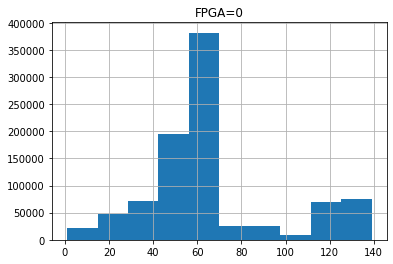

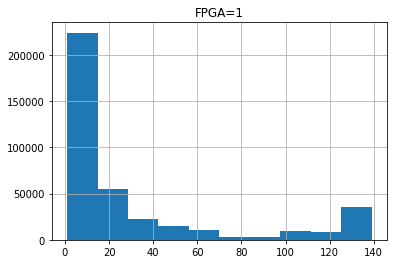

FPGA  TDC_CHANNEL
0     139            75617
      64             64581
      63             63724
Name: TDC_MEAS, dtype: int64
FPGA  TDC_CHANNEL
1     2              32669
      139            32442
      1              28438
Name: TDC_MEAS, dtype: int64
Unique orbits:  11001
Unique orbits in channel 139:  10976


In [4]:
#1. Create a Pandas DataFrame reading N rows of the 'data_000637.txt' dataset
df_fpga = pd.read_csv('./data/data_000637.txt')
df1 = df_fpga.head(np.random.randint(10000, df_fpga.shape[0])) # I select a random sample of the rows starting from the beginning of DAQ process
print(df1)


#2. Find out the number of BX in a ORBIT 
x = df1['BX_COUNTER'].max() + 1
print('Number of BX in an ORBIT is', x)


#3. Find out how much the data taking lasted
#First with the whole dataset: 
daq_time = (df_fpga['ORBIT_CNT'].max()-df_fpga['ORBIT_CNT'].min())*x*25*m.pow(10,-9)
print('Time taken for the whole data acquisition is', daq_time, 's')
#Then estimating from the fraction of dataset I took
daq_time_estimate = (df1['ORBIT_CNT'].max()-df1['ORBIT_CNT'].min())*x*25*m.pow(10,-9)*(df_fpga.shape[0]/df1.shape[0])
print('Estimation of daq time from', np.round((df1.shape[0]*100/df_fpga.shape[0]),2), '% of dataset is', daq_time_estimate,'s')


#4. Create a new column with the absolute time in ns
df_fpga['T_STAMP(s)'] = ((df_fpga['ORBIT_CNT']-df_fpga['ORBIT_CNT'].min())*x*25.+df_fpga['BX_COUNTER']*25+df_fpga['TDC_MEAS']*5/6)*1e-9
print(df_fpga)


#5. Replace the values (all 1) of the HEAD column randomly with 0 or 1
df2 = df_fpga.copy()
df2['HEAD'] = np.random.randint(0,2, size = df2.shape[0])


#6. Create a new DataFrame that contains only the rows with HEAD=1
df_allHEAD1 = df2[df2['HEAD'] == 1]


#7. Make two occupancy plots (one for each FPGA), i.e. plot the number of counts per TDC channel
fpga0 = df_fpga[df_fpga['FPGA']==0]
fpga0.hist('TDC_CHANNEL')
plt.title('FPGA=0')
fpga1 = df_fpga[df_fpga['FPGA']==1]
fpga1.hist('TDC_CHANNEL')
plt.title('FPGA=1')
plt.show()


#8. Use the groupby method to find out the noisy channels
print(fpga0.groupby(['FPGA', 'TDC_CHANNEL'])['TDC_MEAS'].count().sort_values(ascending = False).head(3))
print(fpga1.groupby(['FPGA', 'TDC_CHANNEL'])['TDC_MEAS'].count().sort_values(ascending = False).head(3))



#9. Count the number of unique orbits.
#Unique orbits
print('Unique orbits: ', df_fpga['ORBIT_CNT'].nunique())
#Unique orbits afferenti al canale 139
df_ch139 = df_fpga[df_fpga['TDC_CHANNEL']==139]
print('Unique orbits in channel 139: ', df_ch139['ORBIT_CNT'].nunique())
